In [48]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from PIL import Image
import cv2
import csv
import av
import json
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import models

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
info_json_path = os.path.join(os.getcwd() + "/../Video processing" + os.sep + "video_small" + os.sep + "smaller_transition_times.json")
with open(info_json_path, 'r', encoding='utf-8') as file:
    info_json = json.load(file)

In [5]:
path_to_data = os.path.normpath(os.getcwd() + "/../Image processing" + os.sep + "video_proc/")

In [6]:
train_path = os.path.join(path_to_data, 'train')
val_path = os.path.join(path_to_data, 'val')

In [7]:
# List all files in the directory
image_path = train_path
files = os.listdir(image_path)

# Filter out only image files
image_files = [file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

# If there are image files
if image_files:
    # Get the first image file
    first_image = image_files[0]
    
    # Open the image using Pillow
    with Image.open(os.path.join(image_path, first_image)) as img:
        # Get the size of the image
        width, height = img.size
        # Get the mode of the image
        mode = img.mode
        
        # Get the number of channels based on the mode
        channels = len(mode)
        print(f"The size of the first image '{first_image}' is {width}x{height} pixels.")
        print(f"The image mode is '{mode}' with {channels} channel(s).")
else:
    print("No image files found in the directory.")

The size of the first image '25 Best Trampoline Fail Nominees - FailArmy Hall of Fame (July 2017)18_00.jpg' is 240x240 pixels.
The image mode is 'L' with 1 channel(s).


In [27]:
filename = '25 best'
for i in range(3):
    s = str(i).zfill(2)
    print(filename + '_' + s + '.jpg')

25 best_00.jpg
25 best_01.jpg
25 best_02.jpg


In [17]:
from torchvision.io import read_image

class VideoImageDataset(Dataset):
    def __init__(self, img_dir, device, transform=None, mode='train'):
        self.img_dir = img_dir
        self.transform = transform
        self.mode = mode
        self.device = device
        self.data = self.load_data()
        

    def __len__(self):
        return len(self.data)
    
    def load_data(self):
        data = []
        for filename in info_json:
            if info_json[filename]['category'] != self.mode:
                continue

            csv_path = os.path.join(self.img_dir, filename + '_labels.csv')
            for i in range(25):
                num = str(i).zfill(2)
                img_path = os.path.join(self.img_dir, filename + '_' + num + '.jpg')
                data.append((img_path, csv_path, i))
        
        return data
            
    def __getitem__(self, idx):
        img_path, csv_path, id = self.data[idx]
        image = Image.open(img_path)

        with open(csv_path, 'r', encoding='utf-8') as file:
            csv_reader = csv.reader(file)
            
            row = next(csv_reader)
            label = 0
            # Access the i'th element from the row and parse it as an integer
            try:
                label = int(row[id])
            except IndexError:
                print(f"The index {id} is out of range.")
            except ValueError:
                print(f"The value at index {id} is not an integer.")
            
        if self.transform:
            image = self.transform(image)
        return image, label

In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [66]:
train_dataset = VideoImageDataset(train_path, device=device, transform=transform, mode='train')
val_dataset = VideoImageDataset(val_path, device=device, transform=transform, mode='val')

In [16]:
# Possible data augmentation transforms
RN_transform = transforms.Compose([
    # Resize the image to (224, 224) and convert to RGB
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert single-channel image to RGB
    # Random horizontal flip with probability 0.5
    transforms.RandomHorizontalFlip(p=0.5),
    # Random rotation between -10 and 10 degrees
    transforms.RandomRotation(degrees=(-10, 10)),
    # Random brightness adjustment
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # Convert PIL image to tensor and normalize
    transforms.ToTensor(),
    # Normalize with mean and standard deviation of ImageNet dataset
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [18]:
train_dataset = VideoImageDataset(train_path, device=device, transform=RN_transform, mode='train')
val_dataset = VideoImageDataset(val_path, device=device, transform=RN_transform, mode='val')

In [12]:
for i in range(val_dataset.__len__()):
    img, label = train_dataset.__getitem__(i)
    img = img.permute(1, 2, 0).numpy()
    if label == None:
        print('exist None labels')
    # plt.imshow(img, cmap='gray')
    # plt.title(f'Label: {label}')
    # plt.axis('off')
    # plt.show()

In [19]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [20]:
for batch_idx, (images, labels) in enumerate(train_dataloader):
    # Access image-label tuple at a specific index
    index = 10  # Example index
    if batch_idx * train_dataloader.batch_size <= index < (batch_idx + 1) * train_dataloader.batch_size:
        image, label = images[index % train_dataloader.batch_size], labels[index % train_dataloader.batch_size]
        # Use image and label as needed
        print("Image shape:", image.shape)
        print("Label:", label)
        break  # Break the loop after accessing the desired tuplef

Image shape: torch.Size([3, 224, 224])
Label: tensor(1)


In [22]:
from tqdm import tqdm

for images, labels in tqdm(train_dataloader):
    # Move data to GPU
    images = images.to(device)
    labels = labels.to(device)

for images, labels in tqdm(val_dataloader):
    # Move data to GPU
    images = images.to(device)
    labels = labels.to(device)

100%|██████████| 94/94 [01:26<00:00,  1.08it/s]


In [23]:
import torch
import pickle

# Save train and val datasets
with open('train_dataset.pkl', 'wb') as f:
    pickle.dump(train_dataset, f)

with open('val_dataset.pkl', 'wb') as f:
    pickle.dump(val_dataset, f)

# Save train and val dataloaders
with open('train_dataloader.pkl', 'wb') as f:
    pickle.dump(train_dataloader, f)

with open('val_dataloader.pkl', 'wb') as f:
    pickle.dump(val_dataloader, f)



In [ ]:
from models import NaiveCNN

# Initialize the model
test_model = NaiveCNN.NaiveCNN().to(device)

# Print the model architecture
print(test_model)

test_model.load_state_dict(torch.load('checkpoints/NaiveCNN.pth', map_location=device))


In [ ]:
from models import ResNet34

model = ResNet34.ModResNet().to(device)
print(model)


In [25]:
train_target = []
val_target = []
for i in range(train_dataset.__len__()):
    img, label = train_dataset.__getitem__(i)
    train_target.append(label)

for i in range(val_dataset.__len__()):
    img, label = val_dataset.__getitem__(i)
    val_target.append(label)

In [ ]:
print(train_target)
print(val_target)

In [26]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(np.array([0, 1])), y=train_target)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print(class_weights)

tensor([0.7023, 1.7359], device='cuda:0')


In [79]:
from tqdm import tqdm
from sklearn.metrics import f1_score
import torch.optim as optim
import torch.nn as nn
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define your model, loss function, and optimizer
model = NaiveCNN().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.SGD(model.parameters(), lr=0.02, weight_decay=0.001)

# Lists to store training and validation metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
f1_scores = []

In [35]:
from tqdm import tqdm
from sklearn.metrics import f1_score
import torch.optim as optim

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define your model, loss function, and optimizer
model = ResNet34.ModResNet().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.SGD(model.parameters(), lr=0.005, weight_decay=0.0005)

# Lists to store training and validation metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
train_f1_scores = []
val_f1_scores = []

c:\Users\frank\.conda\envs\m_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\frank\.conda\envs\m_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    train_preds = []
    train_targets = []
    # Iterate over the training dataset
    for images, labels in tqdm(train_dataloader, desc=f'Training Epoch {epoch+1}/{num_epochs}', unit='batch'):
        # Move images and labels to the GPU
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Compute training accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        train_preds.extend(predicted.cpu().numpy())
        train_targets.extend(labels.cpu().numpy())
        # Update running loss
        running_loss += loss.item()

    # Compute training accuracy and loss for the epoch
    train_epoch_loss = running_loss / len(train_dataloader)
    train_epoch_accuracy = 100 * correct / total

    # Store training loss and accuracy
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    train_f1 = f1_score(train_targets, train_preds, average='macro')
    train_f1_scores.append(train_f1)
    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0
    val_preds = []
    val_targets = []

    with torch.no_grad():
        for val_images, val_labels in tqdm(val_dataloader, desc=f'Validation Epoch {epoch+1}/{num_epochs}', unit='batch'):
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            _, val_predicted = torch.max(val_outputs, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()
            val_running_loss += val_loss.item()

            val_preds.extend(val_predicted.cpu().numpy())
            val_targets.extend(val_labels.cpu().numpy())

    # Compute validation loss, accuracy, and F1 score for the epoch
    val_epoch_loss = val_running_loss / len(val_dataloader)
    val_epoch_accuracy = 100 * val_correct / val_total
    val_f1 = f1_score(val_targets, val_preds, average='macro')
    
    # Store validation loss, accuracy, and F1 score
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)
    val_f1_scores.append(val_f1)

    print(f'Training Epoch [{epoch+1}/{num_epochs}], Loss: {train_epoch_loss:.4f}, Accuracy: {train_epoch_accuracy:.2f}%, F1 Scire: {train_f1:.4f}')
    print(f'Validation Epoch [{epoch+1}/{num_epochs}], Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_accuracy:.2f}%, F1 Score: {val_f1:.4f}')

# Save the trained model to a file
torch.save(model.state_dict(), "checkpoints/ModResNet_groundup.pth")

In [ ]:
model = ResNet34.ModResNet().to(device)
model.load_state_dict(torch.load("checkpoints/ModResNet_groundup.pth", map_location=device))

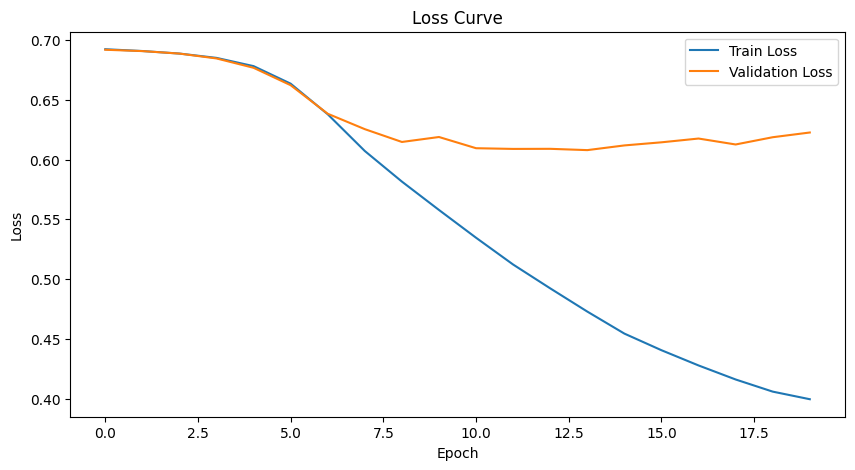

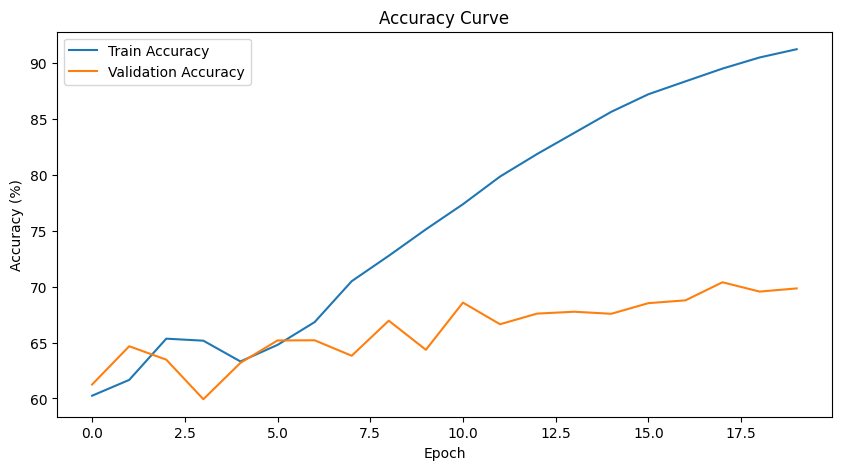

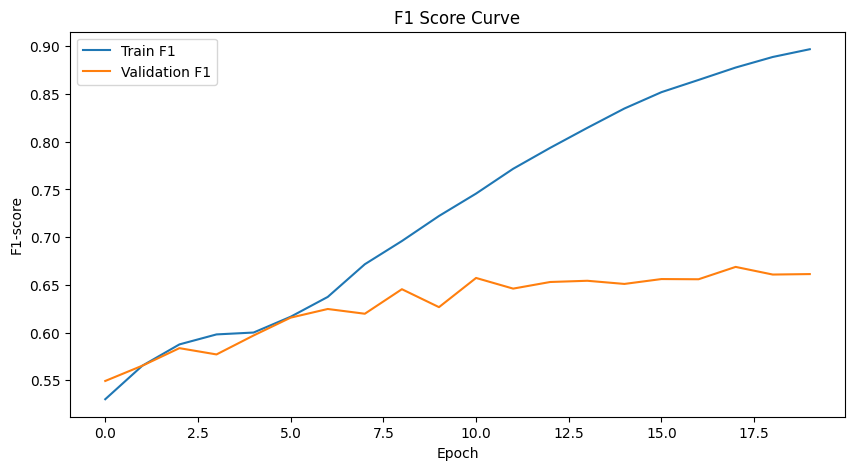

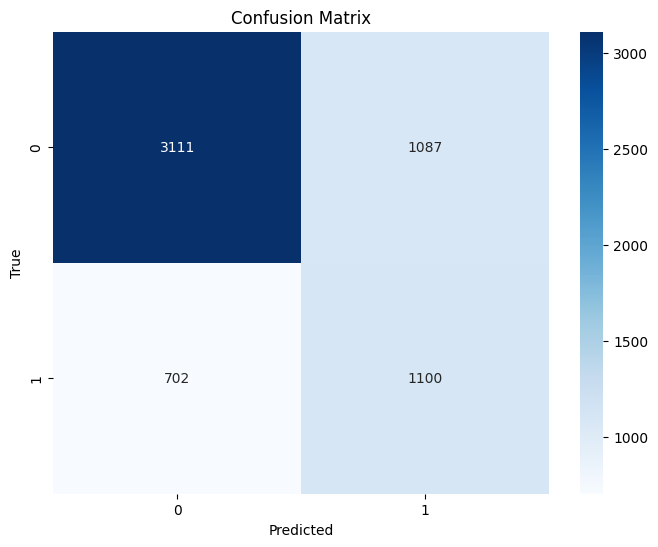

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Plot Accuracy Curve
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

# Plot Accuracy Curve
plt.figure(figsize=(10, 5))
plt.plot(train_f1_scores, label='Train F1')
plt.plot(val_f1_scores, label='Validation F1')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.title('F1 Score Curve')
plt.legend()
plt.show()

# Plot Confusion Matrix
model.eval()  # Ensure model is in evaluation mode
val_preds = []
val_targets = []

with torch.no_grad():
    for val_images, val_labels in tqdm(val_dataloader):
        val_images, val_labels = val_images.to(device), val_labels.to(device)
        val_outputs = model(val_images)
        _, val_predicted = torch.max(val_outputs, 1)
        val_preds.extend(val_predicted.cpu().numpy())
        val_targets.extend(val_labels.cpu().numpy())

cm = confusion_matrix(val_targets, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [44]:
val_f1 = f1_score(val_targets, val_preds, average='macro')
print(val_f1)

0.6640993665046737
